# Sketch Recognition using Simple Neural Network (NN)

In [1]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
# %tensorflow_version 2.x

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
import platform
import pathlib

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.6
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


In [3]:
cache_dir = 'tmp';

In [4]:
# Create cache folder.
!mkdir tmp

mkdir: tmp: File exists


## Load labels

In [5]:
def load_quick_draw_labels(cache_dir=cache_dir):
    labels_url = 'https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt'
    labels_file_name = 'categories.txt'
    
    labels_path = tf.keras.utils.get_file(
        fname=labels_file_name, 
        origin=labels_url,
        cache_dir=pathlib.Path(cache_dir).absolute()
    )
    
    labels_file = open(labels_path, 'r')
    labels = labels_file.read().splitlines()
    labels_file.close()
    
    labels = [label.replace(' ', '_') for label in labels]
    
    return np.array(labels)

In [6]:
labels = load_quick_draw_labels()

print()
print('labels:\n', labels)


labels:
 ['aircraft_carrier' 'airplane' 'alarm_clock' 'ambulance' 'angel'
 'animal_migration' 'ant' 'anvil' 'apple' 'arm' 'asparagus' 'axe'
 'backpack' 'banana' 'bandage' 'barn' 'baseball' 'baseball_bat' 'basket'
 'basketball' 'bat' 'bathtub' 'beach' 'bear' 'beard' 'bed' 'bee' 'belt'
 'bench' 'bicycle' 'binoculars' 'bird' 'birthday_cake' 'blackberry'
 'blueberry' 'book' 'boomerang' 'bottlecap' 'bowtie' 'bracelet' 'brain'
 'bread' 'bridge' 'broccoli' 'broom' 'bucket' 'bulldozer' 'bus' 'bush'
 'butterfly' 'cactus' 'cake' 'calculator' 'calendar' 'camel' 'camera'
 'camouflage' 'campfire' 'candle' 'cannon' 'canoe' 'car' 'carrot' 'castle'
 'cat' 'ceiling_fan' 'cello' 'cell_phone' 'chair' 'chandelier' 'church'
 'circle' 'clarinet' 'clock' 'cloud' 'coffee_cup' 'compass' 'computer'
 'cookie' 'cooler' 'couch' 'cow' 'crab' 'crayon' 'crocodile' 'crown'
 'cruise_ship' 'cup' 'diamond' 'dishwasher' 'diving_board' 'dog' 'dolphin'
 'donut' 'door' 'dragon' 'dresser' 'drill' 'drums' 'duck' 'dumbbell' 'e

## Download dataset

In [7]:
def download_quick_draw_dataset(cache_dir=cache_dir): 
    labels = load_quick_draw_labels()
    
    dataset_base_url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    dataset_file_paths = []
    
    for label in labels:
        dataset_file_name = label + '.npy'
        dataset_url = dataset_base_url + label.replace('_', '%20') + '.npy'
            
        dataset_file_path = tf.keras.utils.get_file(
            fname=dataset_file_name, 
            origin=dataset_url,
            cache_dir=pathlib.Path(cache_dir).absolute()
        )
        
        dataset_file_paths.append(dataset_file_path)
    
    return dataset_file_paths

In [8]:
dataset_file_paths = download_quick_draw_dataset()

In [9]:
%ls -la ./tmp/datasets

total 79859192
drwxr-xr-x  348 trekhleb  staff      11136 Apr 27 13:51 ./
drwxr-xr-x    3 trekhleb  staff         96 Apr 27 12:19 ../
-rw-r--r--    1 trekhleb  staff  105684064 Apr 27 13:44 The_Eiffel_Tower.npy
-rw-r--r--    1 trekhleb  staff  151323840 Apr 27 13:45 The_Great_Wall_of_China.npy
-rw-r--r--    1 trekhleb  staff   95164352 Apr 27 13:45 The_Mona_Lisa.npy
-rw-r--r--    1 trekhleb  staff   91339216 Apr 27 12:19 aircraft_carrier.npy
-rw-r--r--    1 trekhleb  staff  118872512 Apr 27 12:19 airplane.npy
-rw-r--r--    1 trekhleb  staff   96744896 Apr 27 12:19 alarm_clock.npy
-rw-r--r--    1 trekhleb  staff  116035216 Apr 27 12:42 ambulance.npy
-rw-r--r--    1 trekhleb  staff  117393104 Apr 27 12:42 angel.npy
-rw-r--r--    1 trekhleb  staff  108072128 Apr 27 12:42 animal_migration.npy
-rw-r--r--    1 trekhleb  staff   97695888 Apr 27 12:42 ant.npy
-rw-r--r--    1 trekhleb  staff   98965184 Apr 27 12:42 anvil.npy
-rw-r--r--    1 trekhleb  staff  113462128 Apr 27 12:43 apple.npy
-rw-

## Generate training and test datasets

In [10]:
def generate_quick_draw_dataset(
    examples_per_label,
    test_ratio=0.2,
    validation_ratio=0.1,
    cache_dir=cache_dir
):
    labels = load_quick_draw_labels()
    
    pixels_per_drawing = 28 * 28
    
    x = np.empty(shape=(0, pixels_per_drawing));
    y = np.empty(shape=(0), dtype=np.int32);
    
    for label_index, label in enumerate(labels[:10]):
        dataset_file_path = cache_dir + '/datasets/' + label + '.npy'
        images = np.load(dataset_file_path, allow_pickle=False)
        
        images = images[:examples_per_label]
        
        (batch_size, pixels) = images.shape
        
        images_labels = np.full(
            shape=batch_size,
            fill_value=label_index,
            dtype=np.int32
        )

        x = np.concatenate((x, images), axis=0)
        y = np.append(y, images_labels)
           
    permutated_indicex = np.random.permutation(y.shape[0])  
    x = x[permutated_indicex, :]
    y = y[permutated_indicex]
    
    test_dataset_size = int(x.shape[0] * test_ratio)
    validation_dataset_size = int(x.shape[0] * validation_ratio)
    
    x_test = x[0:test_dataset_size, :]
    y_test = y[0:test_dataset_size]
    
    x_val = x[test_dataset_size:(test_dataset_size + validation_dataset_size), :]
    y_val = y[test_dataset_size:(test_dataset_size + validation_dataset_size)]
    
    x_train = x[(test_dataset_size + validation_dataset_size):, :]
    y_train = y[(test_dataset_size + validation_dataset_size):]

    return x_train, y_train, x_test, y_test, x_val, y_val, labels 

In [11]:
x_train, y_train, x_test, y_test, x_val, y_val, labels = generate_quick_draw_dataset(
    examples_per_label=10
)

print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)
print()

print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)
print()

print('x_val.shape: ', x_val.shape)
print('y_val.shape: ', y_val.shape)
print()

print('labels.shape: ', labels.shape)

x_train.shape:  (70, 784)
y_train.shape:  (70,)

x_test.shape:  (20, 784)
y_test.shape:  (20,)

x_val.shape:  (10, 784)
y_val.shape:  (10,)

labels.shape:  (345,)


In [12]:
print(x_train[0])

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   1.  59.  92. 101.  36.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 174. 255. 255. 255. 245.  53.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 131. 255.  89.  30. 216. 228.  25.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   7. 214. 216.   8.  38. 239. 199.   7.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.  64. 254. 148.   1.  73. 252. 154.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 

In [13]:
print(y_train[:10])

[1 7 7 4 4 9 8 8 8 5]


In [14]:
def dataset_preview(x, y, labels, preview_images_num=25):
    images_num = x.shape[0] if x.shape[0] < preview_images_num else preview_images_num
    num_cells = math.ceil(math.sqrt(images_num))
    plt.figure(figsize=(10, 10))
    image_size = int(math.sqrt(x[0].shape[0]))
    for image_index in range(images_num):
        plt.subplot(num_cells, num_cells, image_index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            np.reshape(x[image_index], (image_size, image_size)),
            cmap=plt.cm.binary
        )
#         plt.xlabel(labels[y[image_index]])
        plt.xlabel(labels[y[image_index]])
    plt.show()

Train dataset:


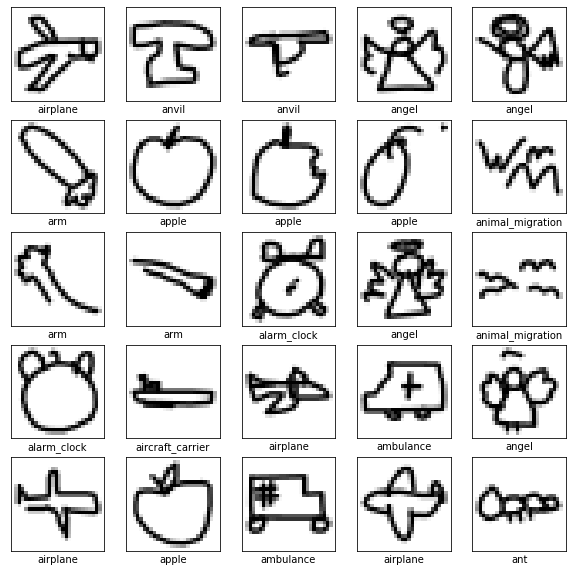

In [17]:
print('Train dataset sample:')
dataset_preview(x_train, y_train, labels)

Test dataset sample:


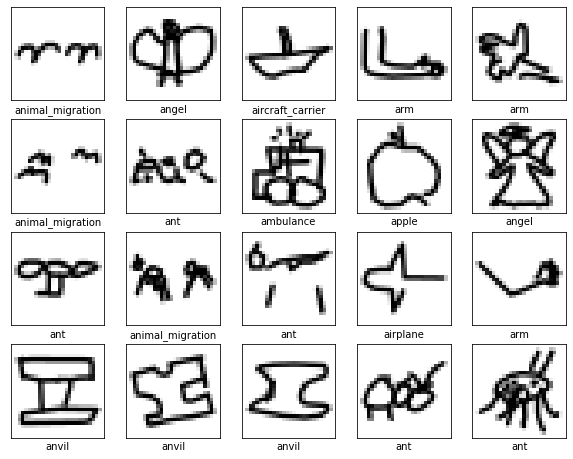

In [18]:
print('Test dataset sample:')
dataset_preview(x_test, y_test, labels)

Validation dataset sample:


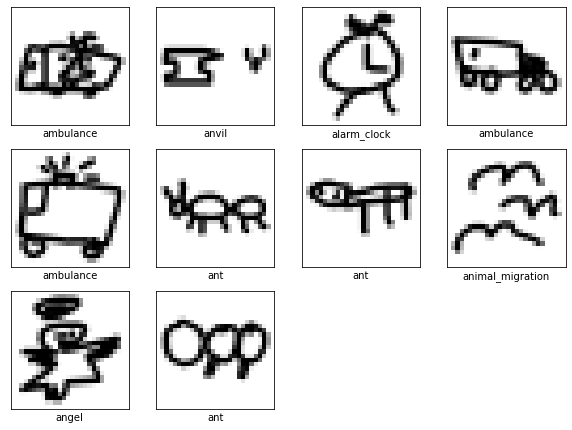

In [19]:
print('Validation dataset sample:')
dataset_preview(x_val, y_val, labels)